# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semana 5

### **Vectores Embebidos de OpenAI**

#### **Nombres y matrículas de los integrantes del equipo:**


* Fernando Omar Salazar Ortiz - A01796214
* Carlos Aaron Bocanegra Buitron - A01796345
* Luis Enrique González González - A01795338
* Gloria María Campos García - A01422345



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')    # para tener acceso a "stopwords" en varios idiomas.

import spacy #Para aplicar la lemmatization
nlp = spacy.load("en_core_web_sm")

from sklearn.model_selection import train_test_split

from collections import Counter

from google.colab import userdata
from openai import OpenAI
import openai

import pickle
from tqdm import tqdm
import numpy as np
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Incluye las celdas necesarias para tu acceso a la API de OpenAI.

api_key = userdata.get("openapikey")

if not api_key:
  raise ValueError("API key no encontrada en los secretos")

client = OpenAI(api_key = api_key)

# **Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [11]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

os.chdir('/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Semana5')

dfa = pd.read_csv('amazon5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfi = pd.read_csv('imdb5.txt', sep=r'\s{3,}', names=['review','label'], header=None, encoding='utf-8', engine='python')
dfy = pd.read_csv('yelp5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')

#Total de registros
print('Total de registros de Amazon:',dfa.shape)
print('Total de registros de IMBD:',dfi.shape)
print('Total de registros de Yelp:',dfy.shape)

df = pd.concat([dfa, dfi, dfy], ignore_index=True)

# *********** Aquí termina la sección de agregar código *************


Total de registros de Amazon: (1000, 2)
Total de registros de IMBD: (1000, 2)
Total de registros de Yelp: (1000, 2)


In [5]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [6]:
#Se verifican los 3000 registros
assert df.shape[0] == 3000
#Se verifican las 2 columnas
assert df.shape[1] == 2
#Se verifica que no haya valores nulos
assert df['review'].isnull().sum() == 0
assert df['label'].isnull().sum() == 0

In [7]:
# Y veamos sus primeros registros:
df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


# **Pregunta - 2:**

Realiza el proceso de limpieza. Aplica el preprocesamiento que consideres adecuado.











In [8]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

def clean_tok(doc):

  #Convertir a minusculas
  docTmp = doc.lower()

  #Sustitucion de negaciones estilo don't por do not

  contractions = {
    r"don't": "do not",
    r"dont": "do not",
    r"doesn't": "does not",
    r"didn't": "did not",
    r"can't": "can not",
    r"cant": "can not",
    r"couldn't": "could not",
    r"won't": "will not",
    r"wouldn't": "would not",
    r"shouldn't": "should not",
    r"mustn't": "must not",
    r"mightn't": "might not",
    r"needn't": "need not",
    r"shan't": "shall not",
    r"hasn't": "has not",
    r"haven't": "have not",
    r"hadn't": "had not",
    r"wasn't": "was not",
    r"weren't": "were not",
    r"isn't": "is not",
    r"aren't": "are not",
  }

  for pattern, replacement in contractions.items():
    docTmp = re.sub(pattern, replacement, docTmp)


  #Reemplazar todos los caracteres no alfabeticos por espacios en blanco
  docTmp2 = re.sub(r'[^a-z]', ' ', docTmp)


  #Tokenizacion usando word_tokenize
  tokensTmp = nltk.word_tokenize(docTmp2)

  #Remover stopwords en ingles
  # Consideremos la siguiente lista de palabras asociada a negaciones en ingles
  negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
  mystopwords = [stopword for stopword in stopwords.words('english') if stopword not in negwords]
  tokensTmp2 = [token for token in tokensTmp if token not in mystopwords]

  tokens = tokensTmp2

  return tokens


def clean_doc(doc):
  tokens = []

  #procesamiento de SO
  tmp = [re.sub(r'^[s]+[o]{2,}$', 'so', token) for token in doc]

  #procesamiento de GOOD
  tmp2 = [re.sub(r'^[g]+[o]{3,}[d]+$', 'good', token) for token in tmp]

  #Reemplazar letras repetidas 3+ por una letra
  tmp3 = [re.sub(r'(.)\1{2,}', r'\1', token) for token in tmp2]

  #Aplicar Lemmatization
  tmp4 = [nlp(token)[0].lemma_ for token in tmp3]

  #tokens = tmp3
  tokens = tmp4

  #print(tokens)
  return tokens



# Separamos la información:
#     La "X" serán los datos de entrada, los comentarios.
#     La "Y" será la variable de salida, la evaluación.
X = df.review
Y = df.label



Xcleantok = [clean_tok(x) for x in X]

Xclean = [clean_doc(x) for x in Xcleantok]

# *********** Aquí termina la sección de agregar código *************

In [9]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:

# comment 27 had 'didn't'

#for x in Xclean[27:28]:
for x in Xclean[0:5]:
  print(x)


['no', 'way', 'plug', 'we', 'unless', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem']
['mic', 'great']


# **Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [10]:

# ************* Inicia la sección de agregar código:*****************************

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)


# *********** Termina la sección de agregar código *************


# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

#Se valida la cantidad de registros
assert len(x_train) == len(y_train) == 2100
assert len(x_val) == len(y_val) == 450
assert len(x_test) == len(y_test) == 450

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta - 4:**



Construye tu vocabulario a continuación


In [14]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

from collections import Counter

def get_filtered_vocabulary(comments, min_freq=2, min_word_length=2):
    filtered_comments = [
        [token for token in comment if len(token) >= min_word_length]
        for comment in comments
    ]

    token_counter = Counter()
    for comment in filtered_comments:
        token_counter.update(comment)

    filtered_vocab = {
        token: freq for token, freq in token_counter.items() if freq >= min_freq
    }

    return filtered_vocab

midicc = get_filtered_vocabulary(x_train, min_freq=1, min_word_length=2)
#print(dictionary)



# *********** Aquí termina la sección de agregar código *************

1. Se eligió la frecuencia mínima de 1 para incluir los comentarios que despues de su proceso de limpieza solamente quedaron con 1 token.
2. Se eligió el tamaño de token a 2 caracteres porque hay muy pocas palabras de 1 caracter en ingles: i, a, m (se debió obtener al convertir "I'm" a: "i m" con el proceso de limpieza) y otros casos similares por el estilo.

In [16]:
# b.	Indica el tamaño del vocabulario generado.

# ******* Inicia la sección de agregar código: ***********

# Mostramos la cantidad de palabras únicas en el diccionario
print('Longitud del diccionario:', len(midicc))


# *********** Aquí termina la sección de agregar código *************

Longitud del diccionario: 3261


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

Principalmente para evitar fuga de datos (data leakage), ya que si usáramos los conjuntos de validación o prueba para generar el vocabulario, estaríamos "contaminando" nuestro modelo con información que no debería conocer durante el entrenamiento. Esto podría llevar a un sobreajuste y a una evaluación poco realista del rendimiento del modelo.

### ++++++++ Termina la sección de agregar texto: +++++++++++


In [17]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])


# *********** Aquí termina la sección de agregar código *************


In [18]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

['co', 'star', 'not', 'fare', 'much', 'well', 'people', 'like', 'morgan', 'freeman', 'jonah', 'hill', 'ed', 'helm', 'waste']
['tonight', 'elk', 'filet', 'special', 'suck']
['pay', 'bill', 'not', 'tip', 'feel', 'server', 'terrible', 'job']
['call', 'steakhouse', 'not', 'properly', 'cook', 'steak', 'not', 'understand']
['however', 'keypad', 'tinny', 'sometimes', 'reach', 'wrong', 'button']


# **Pregunta - 5:**


#### **Incluye aquí un resumen de las características y diferencias que tiene al menos los tres modelos de OpenAI indicados: "text-embedding-3-small", "text-embedding-3-large" y "text-embedding-ada-002".**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

1. text-embedding-3-small:
- Es el modelo más reciente y eficiente
- Genera embeddings de 1536 dimensiones
- Ofrece un buen balance entre rendimiento y costo
- Tiene un mejor rendimiento que ada-002 en la mayoría de las tareas
- Es más rápido y económico que text-embedding-3-large

2. text-embedding-3-large:
- Es el modelo más potente y reciente
- Genera embeddings de 3072 dimensiones
- Ofrece el mejor rendimiento en tareas de búsqueda semántica
- Es más costoso y requiere más recursos computacionales
- Ideal para aplicaciones que requieren máxima precisión

3. text-embedding-ada-002:
- Es el modelo más antiguo de los tres
- Genera embeddings de 1536 dimensiones
- Fue el modelo estándar antes del lanzamiento de la serie 3
- Tiene un rendimiento inferior a los modelos de la serie 3
- Sigue siendo útil para aplicaciones básicas

### ++++++++ Termina la sección de agregar texto: +++++++++++


# **Pregunta - 6:**


#### **Diccionario clave-valor de palabras del diccionario y vectores embebidos.**

In [25]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

modelo = "text-embedding-3-large"

# Generar embeddings y crear diccionario
new_dictionary = {}
total_tokens = 0

# Procesamos por lotes para evitar límites de la API
batch_size = 100
listdicc = sorted(list(midicc))
for i in tqdm(range(0, len(listdicc), batch_size)):
    batch = listdicc[i:i+batch_size]

    # Solicitar embeddings a la API
    response = client.embeddings.create(
        model=modelo,
        input=batch
    )

    # Actualizar contador de tokens
    total_tokens += response.usage.total_tokens

    # Añadir al diccionario
    for j, embedding in enumerate(response.data):
        new_dictionary[batch[j]] = embedding.embedding

# Guardar el diccionario
with open(f'embeddings_{modelo.replace("-", "_")}.pkl', 'wb') as f:
    pickle.dump(new_dictionary, f)

print(f"Proceso completado. Total de tokens utilizados: {total_tokens}")
print(f"Costo aproximado: ${total_tokens/1000 * 0.02 if modelo=='text-embedding-3-small' else total_tokens/1000 * 0.13 if modelo=='text-embedding-3-large' else total_tokens/1000 * 0.0001} USD")
print(f"Dimensión de los vectores: {len(next(iter(new_dictionary.values())))}")


# *********** Aquí termina la sección de agregar código *************

100%|██████████| 33/33 [00:29<00:00,  1.12it/s]


Proceso completado. Total de tokens utilizados: 5571
Costo aproximado: $0.72423 USD
Dimensión de los vectores: 3072


In [28]:
# guardar el nuevo vocabulario
folder_path = '/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Semana5'

with open(os.path.join(folder_path, f'embeddings_{modelo.replace("-", "_")}.pkl'), 'wb') as f:
    pickle.dump(new_dictionary, f)

np_dict = {k: np.array(v) for k, v in new_dictionary.items()}
np.savez_compressed(
    os.path.join(folder_path, f'embeddings_{modelo.replace("-", "_")}.npz'),
    embeddings=np_dict
)

# pintar los primeros registros
pkl_path = f'{folder_path}/embeddings_{modelo.replace("-", "_")}.pkl'

# leemos el vector desde el almacenamiento
with open(pkl_path, 'rb') as f:
    vectores_midicc_guardados = pickle.load(f)

for i, (word, vector) in enumerate(vectores_midicc_guardados.items()):
    print(f"{i+1}. Palabra: '{word}' → Vector: {vector[:5]}...")
    if i >= 4:
        break


1. Palabra: 'aailiyah' → Vector: [0.005438161548227072, 0.006977107375860214, 0.004894760437309742, 0.02832324057817459, 0.0093498220667243]...
2. Palabra: 'abandon' → Vector: [-0.007007264997810125, -0.015100497752428055, 0.003588845254853368, 0.007906953804194927, 0.014838914386928082]...
3. Palabra: 'abhor' → Vector: [-0.033358048647642136, -0.050388824194669724, -0.0016424368368461728, -0.0007754170219413936, 0.011388050392270088]...
4. Palabra: 'ability' → Vector: [-0.038174599409103394, 0.011189106851816177, 0.0041699339635670185, 0.006988861598074436, 0.010401018895208836]...
5. Palabra: 'able' → Vector: [-0.02487010695040226, 0.03475460782647133, -0.010855298489332199, 0.01941598206758499, 0.019451282918453217]...


**Los Tokens que se usaron de OpenAI al obtener los vectores de las 3261 palabras del diccionario fueron 5654 con el modelo: text-embedding-3-large**

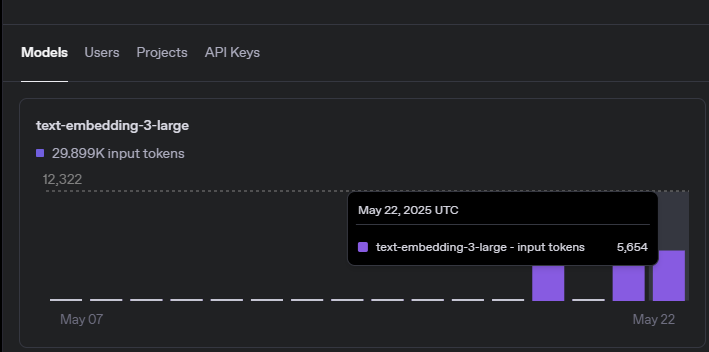


# **Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y prueba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [30]:
len(vectores_midicc_guardados)

3261

In [31]:
len(vectores_midicc_guardados['star'])

3072

In [32]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

dimensiones_vectores = 3072


def comentario_a_vector(comment, embedding_dict):
    vectores = [embedding_dict[token] for token in comment if token in embedding_dict]

    if len(vectores) == 0:
        return np.zeros(len(next(iter(embedding_dict.values()))))
    return np.mean(vectores, axis=0)

# Procesar todos los comentarios
trainEmb = np.array([comentario_a_vector(comentario, vectores_midicc_guardados) for comentario in train_x])
valEmb   = np.array([comentario_a_vector(comentario, vectores_midicc_guardados) for comentario in val_x])
testEmb  = np.array([comentario_a_vector(comentario, vectores_midicc_guardados) for comentario in test_x])

# *********** Aquí termina la sección de agregar código *************

In [33]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (2100, 3072)
Val-Emb: (450, 3072)
Test-Emb: (450, 3072)


# **Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [34]:
solver_list = ['lbfgs', 'liblinear']
penalty_list = ['l1', 'l2']
max_iter_list = [50, 100]
C_list = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
solver_penalty_combinatons = ['lbfgs-l2', 'lbfgs-None', 'liblinear-l1', 'liblinear-l2']
resultados = []

for a in range(len(solver_list)):
  for b in range(len(penalty_list)):
    for c in range(len(max_iter_list)):
      for d in range(len(C_list)):
        if(solver_list[a]+'-'+penalty_list[b] in solver_penalty_combinatons):
          modeloLREmb = LogisticRegression(solver=solver_list[a], penalty=penalty_list[b], max_iter=max_iter_list[c], C=C_list[d])
          modeloLREmb.fit(trainEmb, y_train)

          resultados.append({
              'solver': solver_list[a],
              'penalty': penalty_list[b],
              'max_iter': max_iter_list[c],
              'C': C_list[d],
              'train_accuracy': (100*modeloLREmb.score(trainEmb, y_train)),
              'val_accuracy': (100*modeloLREmb.score(valEmb, y_val)),
              'train_accuracy - val_accuracy': (100*modeloLREmb.score(trainEmb, y_train)) - (100*modeloLREmb.score(valEmb, y_val))
          })

df_resultados = pd.DataFrame(resultados)

df_resultados



,solver,penalty,max_iter,C,train_accuracy,val_accuracy,train_accuracy - val_accuracy
0,lbfgs,l2,50,0.1,83.666667,85.111111,-1.444444
1,lbfgs,l2,50,0.5,86.380952,87.111111,-0.730159
2,lbfgs,l2,50,1.0,87.095238,88.444444,-1.349206
3,lbfgs,l2,50,2.0,88.000000,88.888889,-0.888889
4,lbfgs,l2,50,4.0,89.142857,88.666667,0.476190
5,lbfgs,l2,50,6.0,89.809524,88.222222,1.587302
6,lbfgs,l2,50,8.0,89.857143,87.555556,2.301587
7,lbfgs,l2,50,10.0,90.095238,87.555556,2.539683
8,lbfgs,l2,100,0.1,83.666667,85.111111,-1.444444
9,lbfgs,l2,100,0.5,86.380952,87.111111,-0.730159


In [ ]:
### GridSearchCV para la busqueda hiperparametros de LR ########

'''
param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.1, 0.5, 1.0, 2.0, 4.0],
        'max_iter': [50, 100]
    },
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': [0.1, 0.5, 1.0, 2.0, 4.0],
        'max_iter': [50, 100]
    }
]


modeloLREmb2 = LogisticRegression()
grid_search = GridSearchCV(estimator=modeloLREmb2, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(trainEmb, y_train)


resultados = pd.DataFrame(grid_search.cv_results_)


for mean, std, params in zip(
    resultados['mean_test_score'],
    resultados['std_test_score'],
    resultados['params']
):
  print(f"{mean:.4f} (+/-{std:.4f}) para {params}")
'''

'\nparam_grid = [\n    {\n        \'solver\': [\'liblinear\'],\n        \'penalty\': [\'l1\', \'l2\'],\n        \'C\': [0.1, 0.5, 1.0, 2.0, 4.0],\n        \'max_iter\': [50, 100]\n    },\n    {\n        \'solver\': [\'lbfgs\'],\n        \'penalty\': [\'l2\'],\n        \'C\': [0.1, 0.5, 1.0, 2.0, 4.0],\n        \'max_iter\': [50, 100]\n    }\n]\n\n\nmodeloLREmb2 = LogisticRegression()\ngrid_search = GridSearchCV(estimator=modeloLREmb2, param_grid=param_grid, cv=3, scoring=\'accuracy\')\n\ngrid_search.fit(trainEmb, y_train)\n\n\nresultados = pd.DataFrame(grid_search.cv_results_)\n\n\nfor mean, std, params in zip(\n    resultados[\'mean_test_score\'],\n    resultados[\'std_test_score\'],\n    resultados[\'params\']\n):\n  print(f"{mean:.4f} (+/-{std:.4f}) para {params}")\n'

In [35]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


modeloLREmbFinal = LogisticRegression(solver='liblinear', penalty='l2' , max_iter=100, C=2.0)
modeloLREmbFinal.fit(trainEmb, y_train)


y_pred_val_lr = modeloLREmbFinal.predict(valEmb)

print('LR: Train-accuracy: %.2f%%' % (100*modeloLREmbFinal.score(trainEmb, y_train)))
print('LR: Val-accuracy: %2.f%%' % (100*modeloLREmbFinal.score(valEmb, y_val)))
print('----------------')


print(classification_report(y_val, y_pred_val_lr))
# *********** Aquí termina la sección de agregar código *************


LR: Train-accuracy: 87.81%
LR: Val-accuracy: 89%
----------------
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       216
           1       0.90      0.88      0.89       234

    accuracy                           0.89       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.89      0.89      0.89       450



**Comparando este modelo con el de la semana anterior (matrices de conteo y tf-idf), el hecho de usar embeddings mejoró el modelo, ahora la diferencia del accuracy entre los conjuntos de entrenamiento y validación es mucho menor**

In [36]:
## Para iterar por fors por algunas posibilidades con Random Forest
n_estimators_list = [100, 200]
max_depth_list = [10, 20, None]
min_samples_split_list = [2, 5]
min_samples_leaf_list = [1, 2]
max_features_list = ['sqrt', 'log2']
bootstrap_list = [True, False]
resultados = []

for a in range(len(n_estimators_list)):
  for b in range(len(max_depth_list)):
    for c in range(len(min_samples_split_list)):
      for d in range(len(min_samples_leaf_list)):
        for e in range(len(max_features_list)):
          for f in range(len(bootstrap_list)):
            modeloLREmb = RandomForestClassifier(n_estimators=n_estimators_list[a], max_depth=max_depth_list[b], min_samples_split=min_samples_split_list[c],
                                                 min_samples_leaf=min_samples_leaf_list[d], max_features=max_features_list[e], bootstrap=bootstrap_list[f])
            modeloLREmb.fit(trainEmb, y_train)

            resultados.append({
                'n_estimators': n_estimators_list[a],
                'max_depth': max_depth_list[b],
                'min_samples_split': min_samples_split_list[c],
                'min_samples_leaf': min_samples_leaf_list[d],
                'max_features': max_features_list[e],
                'bootstrap': bootstrap_list[f],
                'train_accuracy': (100*modeloLREmb.score(trainEmb, y_train)),
                'val_accuracy': (100*modeloLREmb.score(valEmb, y_val)),
                'train_accuracy - val_accuracy': (100*modeloLREmb.score(trainEmb, y_train)) - (100*modeloLREmb.score(valEmb, y_val))
            })

df_resultados = pd.DataFrame(resultados)
pd.set_option('display.max_rows', 100)
df_resultados


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,bootstrap,train_accuracy,val_accuracy,train_accuracy - val_accuracy
0,100,10.0,2,1,sqrt,True,99.714286,87.111111,12.603175
1,100,10.0,2,1,sqrt,False,99.952381,86.000000,13.952381
2,100,10.0,2,1,log2,True,99.666667,86.000000,13.666667
3,100,10.0,2,1,log2,False,99.857143,86.222222,13.634921
4,100,10.0,2,2,sqrt,True,99.714286,86.666667,13.047619
5,100,10.0,2,2,sqrt,False,99.904762,86.222222,13.682540
6,100,10.0,2,2,log2,True,99.619048,85.333333,14.285714
7,100,10.0,2,2,log2,False,99.904762,86.000000,13.904762
8,100,10.0,5,1,sqrt,True,99.666667,83.777778,15.888889
9,100,10.0,5,1,sqrt,False,99.904762,86.000000,13.904762


In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
### GridSearchCV para la busqueda hiperparametros de RF ########
'''
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}


modeloRFEmb2 = RandomForestClassifier()
grid_search = GridSearchCV(estimator=modeloRFEmb2, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(trainEmb, y_train)


resultados = pd.DataFrame(grid_search.cv_results_)


for mean, std, params in zip(
    resultados['mean_test_score'],
    resultados['std_test_score'],
    resultados['params']
):
  print(f"{mean:.4f} (+/-{std:.4f}) para {params}")
'''

'\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [10, 20, None],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'bootstrap\': [True, False]\n}\n\n\nmodeloRFEmb2 = RandomForestClassifier()\ngrid_search = GridSearchCV(estimator=modeloRFEmb2, param_grid=param_grid, cv=3, scoring=\'accuracy\')\ngrid_search.fit(trainEmb, y_train)\n\n\nresultados = pd.DataFrame(grid_search.cv_results_)\n\n\nfor mean, std, params in zip(\n    resultados[\'mean_test_score\'],\n    resultados[\'std_test_score\'],\n    resultados[\'params\']\n):\n  print(f"{mean:.4f} (+/-{std:.4f}) para {params}")\n'

In [37]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


modeloRFEmbFinal = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=2, min_samples_split=2, max_features='sqrt', bootstrap=False)
modeloRFEmbFinal.fit(trainEmb, y_train)

y_pred_val_rf = modeloRFEmbFinal.predict(valEmb)

print('\nRF: Train-accuracy: %.2f%%' % (100*modeloRFEmbFinal.score(trainEmb, y_train)))
print('RF: Val-accuracy: %.2f%%' % (100*modeloRFEmbFinal.score(valEmb, y_val)))
print('----------------')

print(classification_report(y_val, y_pred_val_rf))

# *********** Aquí termina la sección de agregar código *************


RF: Train-accuracy: 100.00%
RF: Val-accuracy: 88.00%
----------------
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       216
           1       0.89      0.88      0.88       234

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450



**Al usar el modelo de Random Forest e intentar con varios hiperparámetros se obtuvieron modelos sobrenetrenados (porque la diferencia de accuracy entre los conjuntos de validación y prueba siempre fue amplia, en promedio 15%) por lo que concluimos que el modelo de Random Forest usando los vectores promedio de los comentarios no es una buena solución para el análisis de este conjunto de datos.**

**Comparando este modelo con el de la semana anterior (matrices de conteo y tf-idf), el hecho de usar embeddings no mejoró el modelo porque ahora la diferencia del accuracy entre los conjuntos de entrenamiento y validación es mucho mayor.**

# **Pregunta - 9:**



Reporte del mejor modelo con el conjunto de Prueba (Test).


In [39]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


mejor_modelo_emb = modeloLREmbFinal

print('Test-accuracy con el mejor modelo %.2f%%' % (100*mejor_modelo_emb.score(testEmb, y_test)))

pred = mejor_modelo_emb.predict(testEmb)
print('\nMatriz de confusión con el mejor modelo:')
print(confusion_matrix(y_test, pred, labels=[0,1]))

print('\nMatriz de confusión con el mejor modelo en proporciones:')
print(confusion_matrix(y_test, pred, labels=[0,1]) / pred.shape[0])


print('\nClassification_report:')
print(classification_report(y_test, pred))

# *********** Aquí termina la sección de agregar código *************

Test-accuracy con el mejor modelo 85.56%

Matriz de confusión con el mejor modelo:
[[187  29]
 [ 36 198]]

Matriz de confusión con el mejor modelo en proporciones:
[[0.41555556 0.06444444]
 [0.08       0.44      ]]

Classification_report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       216
           1       0.87      0.85      0.86       234

    accuracy                           0.86       450
   macro avg       0.86      0.86      0.86       450
weighted avg       0.86      0.86      0.86       450



# **Pregunta - 10:**

In [40]:
# Incluye todas las líneas de código y celdas que consideres adecuadas para este ejercicio.


whole_comments = {}

totalcomments = sorted(list(X))
for i in tqdm(range(0, len(totalcomments), batch_size)):
    batch = totalcomments[i:i+batch_size]

    # Solicitar embeddings a la API
    response = client.embeddings.create(
        model=modelo,
        input=batch
    )

    # Actualizar contador de tokens
    total_tokens += response.usage.total_tokens

    # Añadir al diccionario
    for j, embedding in enumerate(response.data):
        whole_comments[batch[j]] = embedding.embedding

# Guardar el diccionario
with open(f'embeddings_{modelo.replace("-", "_")}.pkl', 'wb') as f:
    pickle.dump(whole_comments, f)

print(f"Proceso completado. Total de tokens utilizados: {total_tokens}")
print(f"Costo aproximado: ${total_tokens/1000 * 0.02 if modelo=='text-embedding-3-small' else total_tokens/1000 * 0.13 if modelo=='text-embedding-3-large' else total_tokens/1000 * 0.0001} USD")
print(f"Dimensión de los vectores: {len(next(iter(whole_comments.values())))}")


100%|██████████| 30/30 [00:31<00:00,  1.04s/it]


Proceso completado. Total de tokens utilizados: 49375
Costo aproximado: $6.41875 USD
Dimensión de los vectores: 3072


In [41]:
whole_comments_file_name = 'whole_comments.pkl'

**Los Tokens que se usaron de OpenAI al obtener los vectores de los 3000 comentarios originales fueron 43804 con el modelo: text-embedding-3-large. (Del uso anterior fueron 5654, restados al total de 49458)**



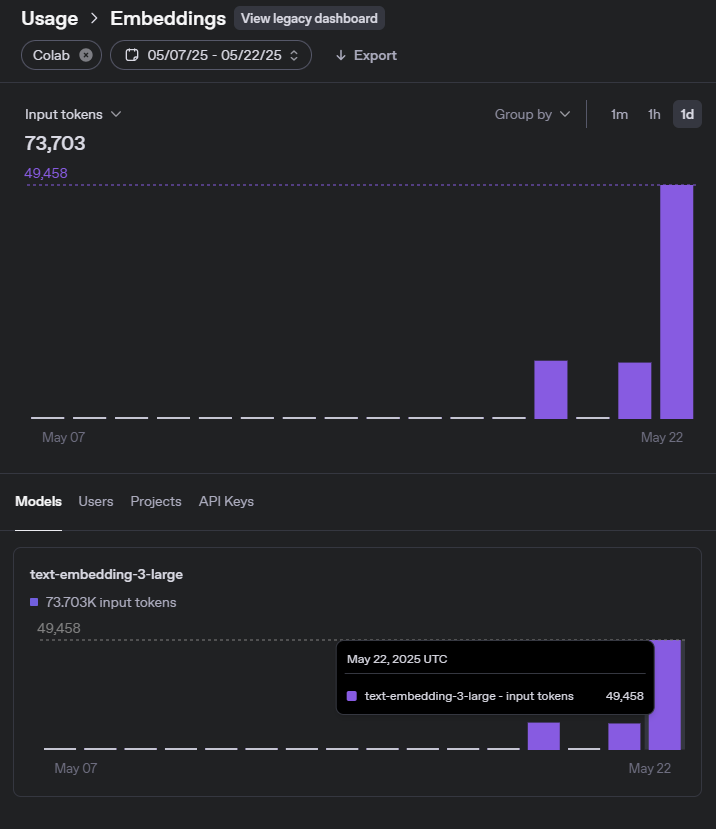

In [ ]:
#len(whole_comments["Works great."])

1536

In [42]:
# guardar los comenarios
folder_path = '/content/drive/MyDrive/Colab Notebooks/MNA/NLP/Semana5'

with open(os.path.join(folder_path, f'embeddings_all-comments_{modelo.replace("-", "_")}.pkl'), 'wb') as f:
    pickle.dump(whole_comments, f)

np_dict = {k: np.array(v) for k, v in whole_comments.items()}
np.savez_compressed(
    os.path.join(folder_path, f'embeddings_all-comments_{modelo.replace("-", "_")}.npz'),
    embeddings=np_dict
)

# pintar los primeros registros
pkl_path = f'{folder_path}/embeddings_all-comments_{modelo.replace("-", "_")}.pkl'

# leemos el vector desde el almacenamiento
with open(pkl_path, 'rb') as f:
    embededd_comments_guardados = pickle.load(f)

for i, (word, vector) in enumerate(embededd_comments_guardados.items()):
    print(f"{i+1}. Palabra: '{word}' → Vector: {vector[:5]}...")
    if i >= 4:
        break


1. Palabra: '!....THE OWNERS REALLY REALLY need to quit being soooooo cheap let them wrap my freaking sandwich in two papers not one!' → Vector: [-0.004280888009816408, -0.02210772968828678, -0.011260264553129673, -0.003191554918885231, 0.02141973003745079]...
2. Palabra: '!I definitly recommend!!' → Vector: [0.000992166344076395, 0.06502792984247208, -0.015409225597977638, -0.005493796430528164, 0.009707646444439888]...
3. Palabra: '#1 It Works - #2 It is Comfortable.' → Vector: [0.024443162605166435, 0.0013488702243193984, -0.015221795998513699, -0.004528934136033058, -0.00034104957012459636]...
4. Palabra: '$50 Down the drain.' → Vector: [-0.008708203211426735, -0.005339101422578096, 0.010597795248031616, -0.036923427134752274, -0.016009263694286346]...
5. Palabra: '& That movie was bad.' → Vector: [-0.03363950923085213, 0.002494657412171364, -0.007229902781546116, 0.021785197779536247, -0.0013044518418610096]...


In [43]:
x_train_comments, x_val_and_test_comments, y_train_comments, y_val_and_test_comments = train_test_split(X, Y, train_size=.70, shuffle=True, random_state=1)
x_val_comments, x_test_comments, y_val_comments, y_test_comments = train_test_split(x_val_and_test_comments, y_val_and_test_comments, test_size=.50, shuffle=True, random_state=17)


# verificemos las dimensiones obtenidas:

print('X,y Train:', len(x_train_comments), len(y_train_comments))
print('X,y Val:', len(x_val_comments), len(y_val_comments))
print('X,y Test', len(x_test_comments), len(y_test_comments))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


In [44]:
#Se genera en np array con los vectores embebidos de cada data set
dimensiones_vectores = 3072


#TRAIN
trainEmbComments = []
for comment in x_train_comments:
    if comment in embededd_comments_guardados:
      trainEmbComments.append(embededd_comments_guardados[comment])
      #print('Si estuvo' + comment)
    else:
      trainEmbComments.append(np.zeros(dimensiones_vectores))
      #print('No estuvo' + comment)

# Se convierte la lista a un array de Numpy
trainEmbComments = np.array(trainEmbComments)

#VAL
valEmbComments = []
for comment in x_val_comments:
    if comment in embededd_comments_guardados:
      valEmbComments.append(embededd_comments_guardados[comment])
    else:
      valEmbComments.append(np.zeros(dimensiones_vectores))

# Se convierte la lista a un array de Numpy
valEmbComments = np.array(valEmbComments)

#TEST
testEmbComments = []
for comment in x_test_comments:
    if comment in embededd_comments_guardados:
      testEmbComments.append(embededd_comments_guardados[comment])
    else:
      testEmbComments.append(np.zeros(dimensiones_vectores))

# Se convierte la lista a un array de Numpy
testEmbComments = np.array(testEmbComments)

In [45]:
solver_list = ['lbfgs', 'liblinear']
penalty_list = ['l1', 'l2']
max_iter_list = [50, 100]
C_list = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]
solver_penalty_combinatons = ['lbfgs-l2', 'lbfgs-None', 'liblinear-l1', 'liblinear-l2']
resultados = []

for a in range(len(solver_list)):
  for b in range(len(penalty_list)):
    for c in range(len(max_iter_list)):
      for d in range(len(C_list)):
        if(solver_list[a]+'-'+penalty_list[b] in solver_penalty_combinatons):
          modeloLREmb_10 = LogisticRegression(solver=solver_list[a], penalty=penalty_list[b], max_iter=max_iter_list[c], C=C_list[d])
          modeloLREmb_10.fit(trainEmbComments, y_train_comments)

          resultados.append({
              'solver': solver_list[a],
              'penalty': penalty_list[b],
              'max_iter': max_iter_list[c],
              'C': C_list[d],
              'train_accuracy': (100*modeloLREmb_10.score(trainEmbComments, y_train_comments)),
              'val_accuracy': (100*modeloLREmb_10.score(valEmbComments, y_val_comments)),
              'train_accuracy - val_accuracy': (100*modeloLREmb_10.score(trainEmbComments, y_train_comments)) - (100*modeloLREmb_10.score(valEmbComments, y_val_comments))
          })

df_resultados = pd.DataFrame(resultados)
pd.set_option('display.max_rows', 100)
df_resultados

,solver,penalty,max_iter,C,train_accuracy,val_accuracy,train_accuracy - val_accuracy
0,lbfgs,l2,50,0.1,98.571429,98.888889,-0.317460
1,lbfgs,l2,50,0.5,98.809524,98.666667,0.142857
2,lbfgs,l2,50,1.0,98.809524,98.888889,-0.079365
3,lbfgs,l2,50,2.0,98.904762,98.888889,0.015873
4,lbfgs,l2,50,4.0,99.190476,98.666667,0.523810
5,lbfgs,l2,50,6.0,99.285714,98.666667,0.619048
6,lbfgs,l2,50,8.0,99.380952,98.666667,0.714286
7,lbfgs,l2,50,10.0,99.476190,98.666667,0.809524
8,lbfgs,l2,100,0.1,98.571429,98.888889,-0.317460
9,lbfgs,l2,100,0.5,98.809524,98.666667,0.142857


In [46]:
pd.set_option('display.max_rows', 10)

In [47]:
modeloLREmb_10_final = LogisticRegression(solver='liblinear', penalty='l1' , max_iter=100, C=0.5)
modeloLREmb_10_final.fit(trainEmbComments, y_train_comments)


y_pred_val_comments_lr = modeloLREmb_10_final.predict(valEmbComments)

print('LR: Train-accuracy: %.2f%%' % (100*modeloLREmb_10_final.score(trainEmbComments, y_train_comments)))
print('LR: Val-accuracy: %2.f%%' % (100*modeloLREmb_10_final.score(valEmbComments, y_val_comments)))
print('----------------')


print(classification_report(y_val_comments, y_pred_val_comments_lr))

LR: Train-accuracy: 96.33%
LR: Val-accuracy: 96%
----------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       216
           1       0.98      0.94      0.96       234

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



**Para el modelo de Regresión Logística, comparando el uso de los vectores promedio y el uso de los vectores del comentario original, se obtuvieron resultados mejores al usar el embedding del comentario completo. Mejorando el accuracy de un 89% a un 96%. Una mejoría sustancial.**

In [48]:
n_estimators_list = [100, 200]
max_depth_list = [10, 20, None]
min_samples_split_list = [2, 5]
min_samples_leaf_list = [1, 2]
max_features_list = ['sqrt', 'log2']
bootstrap_list = [True, False]
resultados = []

for a in range(len(n_estimators_list)):
  for b in range(len(max_depth_list)):
    for c in range(len(min_samples_split_list)):
      for d in range(len(min_samples_leaf_list)):
        for e in range(len(max_features_list)):
          for f in range(len(bootstrap_list)):
            modeloLREmb = RandomForestClassifier(n_estimators=n_estimators_list[a], max_depth=max_depth_list[b], min_samples_split=min_samples_split_list[c],
                                                 min_samples_leaf=min_samples_leaf_list[d], max_features=max_features_list[e], bootstrap=bootstrap_list[f])
            modeloLREmb.fit(trainEmbComments, y_train_comments)

            resultados.append({
                'n_estimators': n_estimators_list[a],
                'max_depth': max_depth_list[b],
                'min_samples_split': min_samples_split_list[c],
                'min_samples_leaf': min_samples_leaf_list[d],
                'max_features': max_features_list[e],
                'bootstrap': bootstrap_list[f],
                'train_accuracy': (100*modeloLREmb.score(trainEmbComments, y_train_comments)),
                'val_accuracy': (100*modeloLREmb.score(valEmbComments, y_val_comments)),
                'train_accuracy - val_accuracy': (100*modeloLREmb.score(trainEmbComments, y_train_comments)) - (100*modeloLREmb.score(valEmbComments, y_val_comments))
            })

df_resultados = pd.DataFrame(resultados)
pd.set_option('display.max_rows', 100)
df_resultados


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,bootstrap,train_accuracy,val_accuracy,train_accuracy - val_accuracy
0,100,10.0,2,1,sqrt,True,99.904762,98.666667,1.238095
1,100,10.0,2,1,sqrt,False,99.952381,98.888889,1.063492
2,100,10.0,2,1,log2,True,100.000000,98.888889,1.111111
3,100,10.0,2,1,log2,False,100.000000,98.666667,1.333333
4,100,10.0,2,2,sqrt,True,99.904762,98.666667,1.238095
5,100,10.0,2,2,sqrt,False,99.952381,99.111111,0.841270
6,100,10.0,2,2,log2,True,100.000000,99.111111,0.888889
7,100,10.0,2,2,log2,False,100.000000,98.444444,1.555556
8,100,10.0,5,1,sqrt,True,99.904762,98.888889,1.015873
9,100,10.0,5,1,sqrt,False,99.952381,98.888889,1.063492


In [49]:
pd.set_option('display.max_rows', 10)

In [50]:
modeloRFEmb_10_final = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', bootstrap=True)
modeloRFEmb_10_final.fit(trainEmbComments, y_train_comments)

y_pred_val_comments_rf = modeloRFEmb_10_final.predict(valEmbComments)

print('\nRF: Train-accuracy: %.2f%%' % (100*modeloRFEmb_10_final.score(trainEmbComments, y_train_comments)))
print('RF: Val-accuracy: %.2f%%' % (100*modeloRFEmb_10_final.score(valEmbComments, y_val_comments)))
print('----------------')

print(classification_report(y_val_comments, y_pred_val_comments_rf))


RF: Train-accuracy: 99.90%
RF: Val-accuracy: 98.44%
----------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       216
           1       0.98      0.99      0.99       234

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



**Para el modelo de Random Forest, comparando el uso de los vectores promedio y el uso de los vectores del comentario original, se obtuvieron resultados mucho mejores al usar el embedding del comentario completo. Mejorando el accuracy de un 88% hasta un 98%. Pero lo más importante fue que el modelo ya no esta sobreentrenado.**

In [51]:
mejor_modelo_emb_comments = modeloLREmb_10_final

print('Test-accuracy con el mejor modelo %.2f%%' % (100*mejor_modelo_emb.score(testEmbComments, y_test_comments)))

pred = mejor_modelo_emb_comments.predict(testEmbComments)
print('\nMatriz de confusión con el mejor modelo:')
print(confusion_matrix(y_test_comments, pred, labels=[0,1]))

print('\nMatriz de confusión con el mejor modelo en proporciones:')
print(confusion_matrix(y_test_comments, pred, labels=[0,1]) / pred.shape[0])


print('\nClassification_report:')
print(classification_report(y_test_comments, pred))

Test-accuracy con el mejor modelo 98.67%

Matriz de confusión con el mejor modelo:
[[210   6]
 [  8 226]]

Matriz de confusión con el mejor modelo en proporciones:
[[0.46666667 0.01333333]
 [0.01777778 0.50222222]]

Classification_report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       216
           1       0.97      0.97      0.97       234

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



# **Pregunta - 11:**



Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++
El trabajo nos ayudó a profundizar en el uso de herramientas externas para generar los embeddings.
Cada miembro uso un modelo diferente o plataforma distinta para evaluar con cual obteníamos mejores resultados.
En el caso de Hugging face, encontramos que el embedding era muy pequeño lo que terminó entregando resultados no tan precisos.
En el caso de OpenAI, probamos con el modelo small y large, siendo este segundo el que generaba mas información para procesar y un porcentaje de accuracy mayor que el resto.

Tambien encontramos algunas conclusiones a nivel de los modelos trabajados:

1. El uso de los embeddings para los modelos de Regresión Logística y Random Forest mejora sustancialmente los resultados de accuracy hasta un 10% en ambos casos.
2. El uso de los embeddings para el modelo de Random Forest elimina el sobreentrenamiento que se obtenía al utilizar el embedding promedio.
3. Se obtuvieron mejores resultados con el modelo text-embedding-3-large (vectores de 3072 dimensiones) con respecto a text-embedding-3-small (vectores de 1536 dimensiones)y al modelo gratuito de HuggingFace (vectores de 384 dimensiones).


### ++++++++ Termina la sección de agregar texto: +++++++++++

# **Fin de la Actividad de Vectores Embebidos - OpenAI**